In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from warnings import catch_warnings
from warnings import filterwarnings

In [38]:
# Import data using datetime and set index to datetime
df = pd.read_csv(r'D:\aa\working_results\Book3.CSV',
                                parse_dates=['Date'],
                                index_col=['Date'])

df.head()

,pm25,pm10,no2,so2,co,o3
Date,,,,,,
2017-10-17 10:00:00,110.75,234.67,82.22,101.55,1.06,27.12
2017-10-17 11:00:00,165.34,536.91,49.09,130.76,0.98,87.85
2017-10-17 12:00:00,130.91,555.58,43.34,129.64,0.53,79.69
2017-10-17 13:00:00,126.39,556.05,32.97,103.30,0.40,78.19
2017-10-17 14:00:00,131.90,504.41,42.27,94.55,0.17,72.72


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45267 entries, 2017-10-17 10:00:00 to 2022-12-16 12:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pm25    45267 non-null  float64
 1   pm10    45267 non-null  float64
 2   no2     45267 non-null  float64
 3   so2     45267 non-null  float64
 4   co      45267 non-null  float64
 5   o3      45267 non-null  float64
dtypes: float64(6)
memory usage: 2.4 MB


<AxesSubplot:>

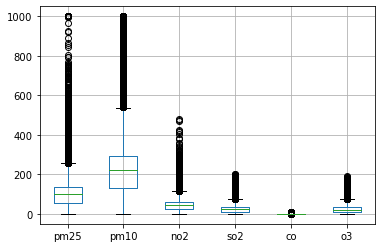

In [40]:

#Box plot
#pd.options.display.mpl_style = False
df.boxplot()

In [41]:
#Normalising data
from sklearn.preprocessing import MinMaxScaler

values = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

In [42]:
scaled_dataset[:2,:]

array([[0.11073332, 0.23459581, 0.17135651, 0.50820821, 0.10739615,
        0.1394164 ],
       [0.16532496, 0.53686906, 0.10230115, 0.6544044 , 0.09929078,
        0.45195821]])

In [43]:
#Creating a window for previous data
def to_supervised(train):
    window_size = 4
    X = []
    Y = []
    for i in range(window_size, len(train)):
        X.append(train[i-window_size:i,:])
        Y.append(train[i,0:1])
    
    return X,Y

In [44]:
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)

Y (45263, 1)
X (45263, 4, 6)


In [45]:
#Splitting the dataset 365*0.2=73
#Splitting the dataset 365*0.3=110
n_train = 73
X_train, X_test = X[n_train:,] , X[:n_train,]
print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)

Y_train, Y_test = Y[n_train:,] , Y[:n_train,]
print('Y_train' ,Y_train.shape)
print('Y_test' ,Y_test.shape)

X_train (45190, 4, 6)
X_test (73, 4, 6)
Y_train (45190, 1)
Y_test (73, 1)


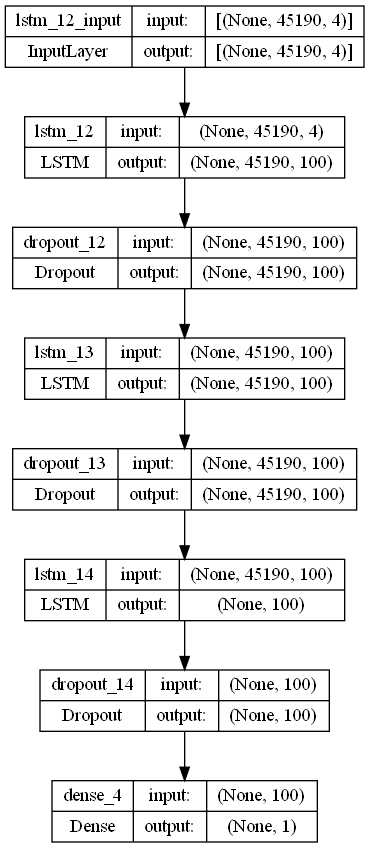

In [76]:
#Importing LSTM model
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
import tensorflow as tf
model = Sequential()

#units means number of neurons
model.add(LSTM(units = 100, return_sequences = True, input_shape=(X_train.shape[0], X_train.shape[1])))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

 
#opt1 = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0, nesterov=False, name="SGD")

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=opt)
tf.keras.utils.plot_model(model=model, show_shapes=True)

In [77]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 45190, 100)        42000     
                                                                 
 dropout_12 (Dropout)        (None, 45190, 100)        0         
                                                                 
 lstm_13 (LSTM)              (None, 45190, 100)        80400     
                                                                 
 dropout_13 (Dropout)        (None, 45190, 100)        0         
                                                                 
 lstm_14 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_14 (Dropout)        (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [82]:
history = model.fit(X_train, Y_train, epochs=5,
                    batch_size=8, validation_data=(X_train,Y_train),
                    verbose=2, shuffle=False)

Epoch 1/5


ValueError: in user code:

    File "C:\Users\91783\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\91783\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\91783\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\91783\anaconda3\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\91783\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\91783\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 45190, 4), found shape=(None, 4, 6)


In [61]:
#Taking predictions
Y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, Y_pred)

print(mse)
rmse = np.sqrt(mse)
print(rmse)

3/3 [==============================] - 0s 44ms/step
0.08641741248276935
0.29396838687649623


In [62]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(Y_test, Y_pred)
print('MAPE', mape)

MAPE 103.2421656444615


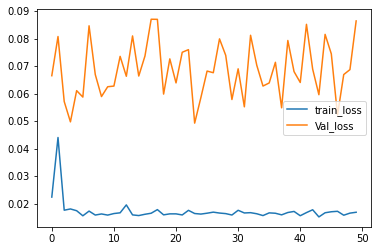

In [63]:
# plot history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='Val_loss')
plt.legend()
plt.show()

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

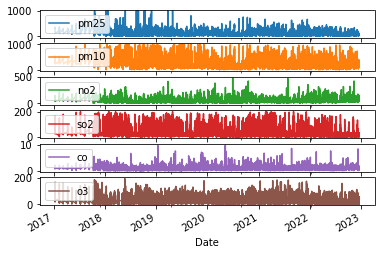

In [64]:
# A simple plot to visualize the correlation between the columns
df.plot(subplots=True)
#df.plot(subplots=True,figsize=(15,13));

In [65]:
#Scaling back to the original scale
d = scaled_dataset[:255,:]
print('dummy',d.shape)
print('Y_pred',Y_pred.shape)
Y_predicted = np.concatenate((Y_pred,d[:73,1:]), axis =1)
print('concat y_pred',Y_pred.shape)
Y_tested = np.concatenate((Y_test, d[:73,1:]), axis = 1)
print('concat Y_test', Y_test.shape)

dummy (255, 6)
Y_pred (73, 1)
concat y_pred (73, 1)
concat Y_test (73, 1)


In [66]:
Y_predicted = scaler.inverse_transform(Y_predicted)
Y_tested = scaler.inverse_transform(Y_tested)
Y_predicted = Y_predicted[:,0:1]
Y_tested = Y_tested[:,0:1]
print('Y_tested', Y_tested.shape)
print('Y_predicted', Y_predicted.shape)

Y_tested (73, 1)
Y_predicted (73, 1)


In [67]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_tested, Y_predicted)

rmse = np.sqrt(mse)
rmse

293.9595678248899

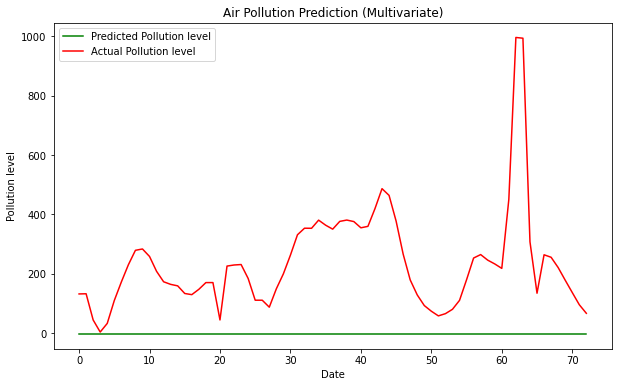

<Figure size 432x288 with 0 Axes>

In [68]:
#Plot the graph between actual vs predicted values
plt.figure(figsize=(10,6))  
plt.plot(Y_predicted[:90,:], color= 'green',label = 'Predicted Pollution level')
plt.plot(Y_tested[:90,:] , color = 'red',label = 'Actual Pollution level')
plt.title("Air Pollution Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()
plt.savefig('graph.png')

In [69]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(Y_tested, Y_predicted)
print('MAPE', mape)

MAPE 103.21363345080844


In [70]:
from sklearn.metrics import r2_score
r2 = r2_score(Y_tested, Y_predicted)
r2

-1.9658860245964758

In [71]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_tested, Y_predicted)
#print('Mean squared error', mse)
print('RMSE' , np.sqrt(mse))
print("Mean of Test data ", np.mean(Y_tested))

RMSE 293.9595678248899
Mean of Test data  236.24013698630137


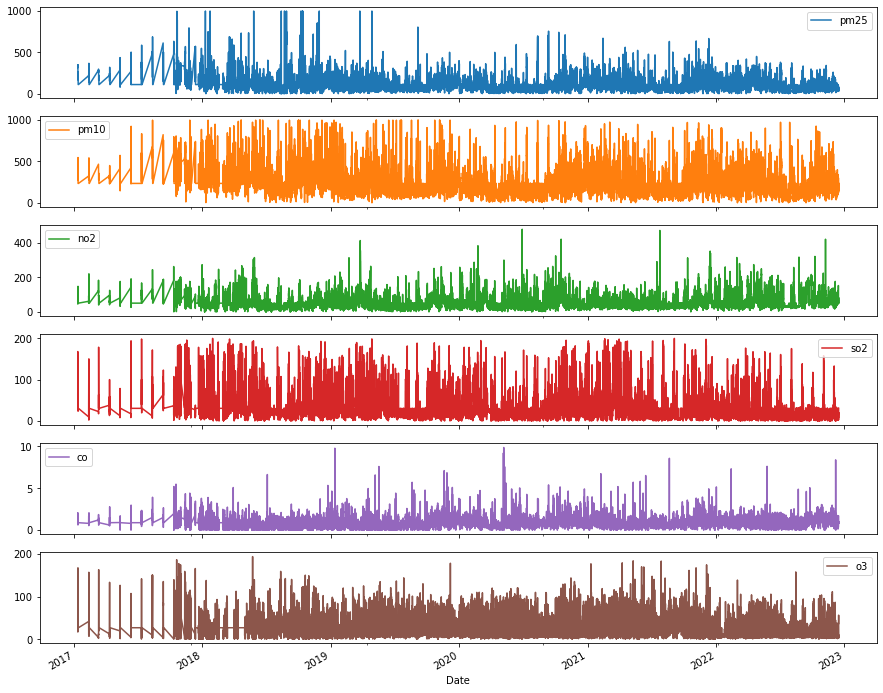

In [72]:
# A simple plot to visualize the correlation between the columns
#df.plot(subplots=True)
df.plot(subplots=True,figsize=(15,13));

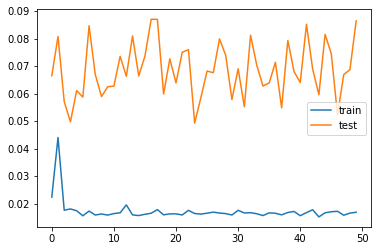

In [73]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()